In [1]:
'''
ICC Tutorial - June 14, 2021
Tutorial 14: Machine Learning for MIMO Systems with Large Arrays
Aldebaro Klautau (UFPA), Nuria Gonzalez-Prelcic (NCSU) and Robert W. Heath Jr. (NCSU)
'''
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from ml4comm_plot_decision_regions import plot_decision_boundary
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (
    Dense,
    LSTM,
    Dropout,
    Lambda,
    Flatten,
    TimeDistributed,
    Conv1D,
    MaxPooling1D
)
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.preprocessing import MinMaxScaler

d:\Programs\Anaconda3\envs\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
d:\Programs\Anaconda3\envs\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
d:\Programs\Anaconda3\envs\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
d:\Programs\Anaconda3\envs\python36\lib\site-packages\tensorflow\python\f

In [2]:
def SER(classifier, X_test, y_test):
    y_pred = classifier.predict(X_test)
    ser    = len(np.where(y_test - y_pred)[0])/len(y_test)
    
    return ser

## Time variant channel problem
Consider a situation where a crazy channel has a cyclic behavior in time, where each time a symbol is sent through the channel the channel has one of 5 possible behaviors. This causes an interesting case, where a conventional classifier can get confused as it probably will not understand the cyclic behavior and therefore will make wrong class predictions.

This way, in this case, a model that can understand the time dependencies of the input can learn the cyclic behavior and predict the correct class as output. In this sense, the long short-term memory(LSTM) model was chosen, as it is prepared to deal with sequence inputs and understand the temporal relationship between them.  

In [3]:
df = pd.read_csv('variable_channel_5_patterns.csv')
channel_output = df['channel_output_r'].to_numpy() + 1j*df['channel_output_i'].to_numpy()
symbs          = df['symbols_r'].to_numpy()+ 1j*df['symbols_i'].to_numpy()
indices        = df['indices'].to_numpy()
M              = 16      # QAM modulation


In [4]:
# Generate dataset
# Train
train_size = int(0.5*len(indices))
y_train = indices[:train_size]
X_train = np.stack([np.real(channel_output[:train_size]),
                    np.imag(channel_output[:train_size])], axis=1)

# Test
y_test = indices[train_size:]
X_test = np.stack([np.real(channel_output[train_size:]),
                   np.imag(channel_output[train_size:])], axis=1)

## Lets have a glimpse of the channel output

In [5]:
def plot_symbols(ch_out_symbs, true_symbs, indices, num_classes):
    custom_cmap = cm.get_cmap('tab20')
    colors = custom_cmap.colors[:num_classes]
    levels = np.arange(num_classes + 2) - 0.5
    y_train = indices[:len(ch_out_symbs)]
    for ii in range(num_classes):
        selected_indices = np.argwhere(y_train==ii)
        selected_indices = selected_indices.reshape((-1))
        plt.plot(ch_out_symbs[selected_indices, 0], ch_out_symbs[selected_indices, 1], 'o', color=colors[ii], label=f'{ii}')
        
    plt.plot(np.real(true_symbs), np.imag(true_symbs), 'rx')
    plt.legend(title='Classes', bbox_to_anchor=(1, 1), loc='upper left', ncol=2, handleheight=2, labelspacing=0.05, frameon=False)
    plt.ylabel('Quadrature')
    plt.xlabel('In-phase')

    plt.show()  

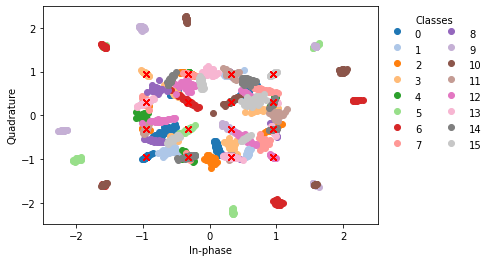

In [6]:
plot_symbols(X_train, symbs, indices, M)

## There is 5 different patterns in this output, these patterns are cyclic in a way we can divide the original channel output into 5 distinct behaviors

In [7]:
n_patterns = 5
channel_output = np.reshape(channel_output, (int(len(channel_output)/n_patterns),n_patterns))
indices = np.reshape(indices, (int(len(indices)/n_patterns),n_patterns))

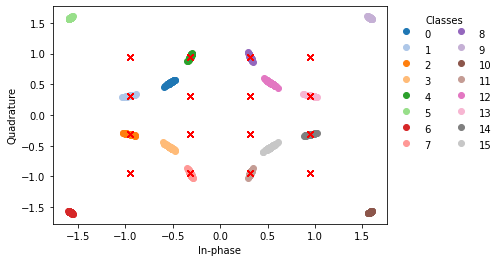

In [8]:
channel_output_slice = np.stack([np.real(channel_output[:,0][:train_size]),
                     np.imag(channel_output[:,0][:train_size])], axis=1)
plot_symbols(channel_output_slice, symbs, indices[:,0], M)

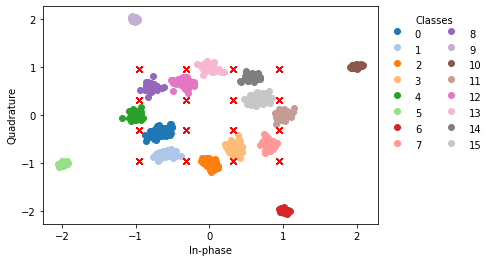

In [9]:
channel_output_slice = np.stack([np.real(channel_output[:,1][:train_size]),
                     np.imag(channel_output[:,1][:train_size])], axis=1)
plot_symbols(channel_output_slice, symbs, indices[:,1], M)

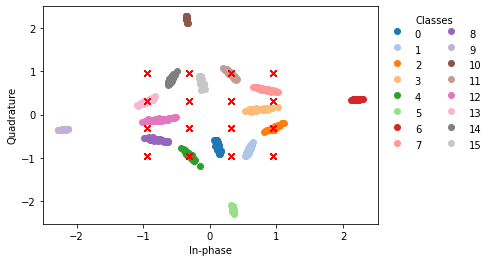

In [10]:
channel_output_slice = np.stack([np.real(channel_output[:,2][:train_size]),
                     np.imag(channel_output[:,2][:train_size])], axis=1)
plot_symbols(channel_output_slice, symbs, indices[:,2], M)

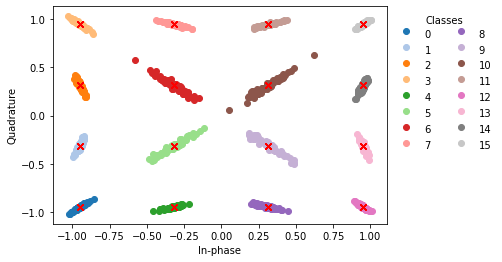

In [11]:
channel_output_slice = np.stack([np.real(channel_output[:,3][:train_size]),
                     np.imag(channel_output[:,3][:train_size])], axis=1)
plot_symbols(channel_output_slice, symbs, indices[:,3], M)

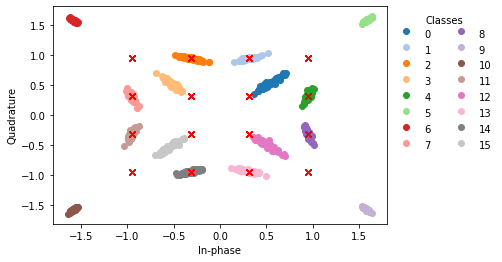

In [12]:
channel_output_slice = np.stack([np.real(channel_output[:,4][:train_size]),
                     np.imag(channel_output[:,4][:train_size])], axis=1)
plot_symbols(channel_output_slice, symbs, indices[:,4], M)

## Now let us try to train a model to predict the symbol desired location without the notion of time dependence behavior

## Decision Tree

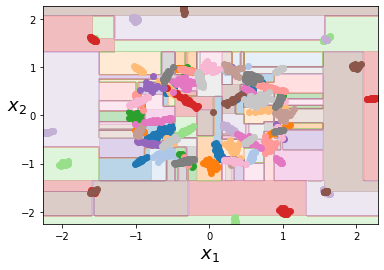

In [13]:
class_DT = DecisionTreeClassifier(max_depth=20, random_state=42)
class_DT.fit(X_train, y_train)
plot_decision_boundary(class_DT, X_train, y_train)

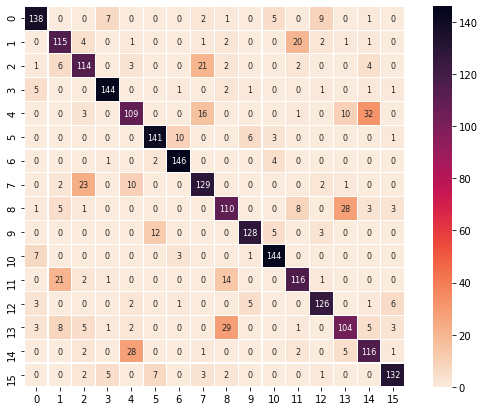

In [14]:
y_pred = class_DT.predict(X_test)
conf_mtx = confusion_matrix(y_test, y_pred)

conf_df = pd.DataFrame(conf_mtx, index = [i for i in range(M)],
                  columns = [i for i in range(M)])
plt.figure(figsize = (10,7))
sns.heatmap(conf_df, cmap=sns.cm.rocket_r, square=True, linewidths=0.1, annot=True, fmt='d', annot_kws={"fontsize": 8})  
plt.show()

In [15]:
ser = SER(class_DT, X_test, y_test)
print(f'Decision Tree:\n SER:\t {ser:.3f}')

acc = accuracy_score(y_test, y_pred)
print(f' Acc:\t {acc:.3f}')

Decision Tree:
 SER:	 0.195
 Acc:	 0.805


## Now let us fit a model that has the notion of time dependency

The model chosen to do so is the long short-term memory(LSTM), with the help of recurrence, this model can take multiple symbols as entry and predict the last symbol class. This way the model can learn the cyclic behavior produced by the variable channel and potentially learn each cycle. 

### First let us generate rolling windows of symbols as the features to our LSTM model

In [16]:
def rolling_window_mtx(x, window_size):
        """Compute all overlapping (rolling) observation windows over a vector 
            and return a matrix

        Args:
            x           : observation vector that is supposed to be split into
                          overlapping windows
            window_size : the target window size

        Returns:

            Window matrix with all windows as rows. That is, if n_windows is the
            number of windows, the result has dimensions:

            (n_windows, window_size)

        """
        if window_size < 1:
            raise ValueError("`window_size` must be at least 1.")
        if window_size > x.shape[-1]:
            raise ValueError("`window_size` is too long.")

        shape = x.shape[:-1] + (x.shape[-1] - window_size + 1, window_size)
        strides = x.strides + (x.strides[-1],)

        return np.lib.stride_tricks.as_strided(x, shape=shape, strides=strides)

In [17]:
channel_output = df['channel_output_r'].to_numpy() + 1j*df['channel_output_i'].to_numpy() # Rx symbol
symbs          = df['symbols_r'].to_numpy()+ 1j*df['symbols_i'].to_numpy() # Tx symbol
indices        = df['indices'].to_numpy() # Tx symbol indices (true label)
features = np.stack([np.real(channel_output),
                    np.imag(channel_output)], axis=1)

In [18]:
n_time_steps = 18 # window size
scaler = MinMaxScaler((-1,1)) # Scale the symbol real and imaginary part
scaler.fit(features)
features = scaler.transform(features)

n_windows   = features.shape[0] - n_time_steps - 1 # Total number of Rolling windows
feature_win = 2 * n_time_steps # Real and imaginnary coordinates of 5 instances
feature_mtx = np.zeros((n_windows, feature_win))
x_train_r = features[:,0]
x_train_i = features[:,1]
rolling_window_mtx( x_train_r[:-1], n_time_steps).shape

# Get the real coordinates and allocate to the first set of columns
feature_mtx[:, range(0, n_time_steps * 2, 2)] = rolling_window_mtx(
     x_train_r[:-1], n_time_steps)[:-1]

# Now we have a set of windows of the real coordinate
# Lets take a look in one window
print(f"\n One window containing just the real coordinates : \n {feature_mtx[0]}")

# Do the same for the imaginary coordinates
feature_mtx[:, range(1, n_time_steps * 2, 2)] = rolling_window_mtx(
                        x_train_i[:-1], n_time_steps)[:-1]

# Lets take a look in the same window
print(f"\n One window with all the coordinates: \n {feature_mtx[0]}")


 One window containing just the real coordinates : 
 [ 0.22878797  0.         -0.28559178  0.          0.96638577  0.
 -0.41970453  0.         -0.14009583  0.          0.13976811  0.
 -0.34354317  0.          0.37934256  0.         -0.15864406  0.
  0.67095159  0.          0.13642539  0.         -0.85847799  0.
  0.24743204  0.         -0.44016713  0.          0.17937325  0.
 -0.14762566  0.         -0.43518306  0.          0.96729051  0.        ]

 One window with all the coordinates: 
 [ 0.22878797  0.23658068 -0.28559178 -0.35816227  0.96638577  0.16190217
 -0.41970453 -0.41396615 -0.14009583 -0.410049    0.13976811 -0.39903004
 -0.34354317  0.22173286  0.37934256  0.24827049 -0.15864406 -0.41679863
  0.67095159  0.6848217   0.13642539 -0.40667999 -0.85847799 -0.42392393
  0.24743204 -0.36681021 -0.44016713  0.44260646  0.17937325 -0.17871921
 -0.14762566 -0.39030274 -0.43518306 -0.01015088  0.96729051  0.16161234]


## Now we need to reshape this feature matrix  the LSTM network
The LSTM network receives as entry feature a matrix of 3 dimensions, these being samples, timestamps, and features. For our problem, we selected 18 timestamps of 2 features (real and imaginary coordinates). This way, the first dimension, the dimension of the sample will contain the timestamps dimension (in this case 18 timestamps) and for last each timestamp will contain 2 features.

In [19]:
shape = feature_mtx.shape

# Reshape the feature matrix to samples, timestamps, features
feature_mtx_3dim = np.reshape(
    feature_mtx, (shape[0], n_time_steps, 2))

## Generate the labels of an LSTM network
Now for the labels of the LSTM network, not all the cases require a label matrix of 3 dimensions. The cases where this is required are on sequence to sequence problems, where the model is made to predict a sequence of timestamps of one or more features. However for our problem, the LSTM network needs to predict the output class of the last timestamp feature, this way we can use a label matrix of 2 dimensions, these being samples and label class.

In [20]:
# Get the labels for the feature matrix
label_mtx = rolling_window_mtx(
                    indices[n_time_steps-1:], 1)[:-2]


### Now that we have the label matrix containing the output class we can transform it to a categorical form with a one-hot encoding transformation.

In [21]:
label_mtx_cat = tf.keras.utils.to_categorical(label_mtx)

### With the dataset well defined we can divide between training and test sets and observe one sample of the training features and labels

In [22]:
size = feature_mtx_3dim.shape[0]
lstm_x_train = feature_mtx_3dim[:int(0.5*size)] # Split in 50% the dataset in training and test
lstm_x_test  = feature_mtx_3dim[int(0.5*size):]

lstm_y_train = label_mtx_cat[:int(0.5*size)]
lstm_y_test  = label_mtx_cat[int(0.5*size):]

# Lets take a look in the same window
print(f"One sample unit of the LSTM entry features: \n {lstm_x_train[0]}")
print(f"LSTM features shape: \n {lstm_x_train.shape}")
print(f"\n One sample unit of the LSTM labels: \n {lstm_y_train[0]}")
print(f"LSTM labels shape: \n {lstm_y_train.shape}")

One sample unit of the LSTM entry features: 
 [[ 0.22878797  0.23658068]
 [-0.28559178 -0.35816227]
 [ 0.96638577  0.16190217]
 [-0.41970453 -0.41396615]
 [-0.14009583 -0.410049  ]
 [ 0.13976811 -0.39903004]
 [-0.34354317  0.22173286]
 [ 0.37934256  0.24827049]
 [-0.15864406 -0.41679863]
 [ 0.67095159  0.6848217 ]
 [ 0.13642539 -0.40667999]
 [-0.85847799 -0.42392393]
 [ 0.24743204 -0.36681021]
 [-0.44016713  0.44260646]
 [ 0.17937325 -0.17871921]
 [-0.14762566 -0.39030274]
 [-0.43518306 -0.01015088]
 [ 0.96729051  0.16161234]]
LSTM features shape: 
 (2490, 18, 2)

 One sample unit of the LSTM labels: 
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
LSTM labels shape: 
 (2490, 16)


## Define the LSTM

In [23]:
lr=0.01
lr_decay=0.0001
optimizer = Adam(lr=lr, decay=lr_decay)
n_epochs=200
n_mini_batch=60

n_timesteps, n_features, n_outputs = lstm_x_train.shape[1], lstm_x_train.shape[2], lstm_y_train.shape[1]
lstm_categorical = Sequential()
lstm_categorical.add(LSTM(100, input_shape=(n_timesteps,n_features), return_sequences=True))
lstm_categorical.add(LSTM(100))
lstm_categorical.add(Dropout(0.5))
lstm_categorical.add(Dense(100, activation='relu'))
lstm_categorical.add(Dense(100, activation='relu'))
lstm_categorical.add(Dense(n_outputs, activation='softmax'))
lstm_categorical.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


## Train the model

In [24]:
history = lstm_categorical.fit(
            lstm_x_train,
            lstm_y_train,
            batch_size=n_mini_batch,
            epochs=n_epochs,
        )

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/200
2490/2490 [==============================] - 7s 3ms/sample - loss: 2.7769 - acc: 0.0747
Epoch 2/200
2490/2490 [==============================] - 3s 1ms/sample - loss: 2.7747 - acc: 0.0751
Epoch 3/200
2490/2490 [==============================] - 3s 1ms/sample - loss: 2.7731 - acc: 0.0727
Epoch 4/200
2490/2490 [==============================] - 2s 1ms/sample - loss: 2.7720 - acc: 0.0747 1s - loss
Epoch 5/200
2490/2490 [==============================] - 2s 995us/sample - loss: 2.7720 - acc: 0.0735
Epoch 6/200
2490/2490 [==============================] - 3s 1ms/sample - loss: 2.7558 - acc: 0.0867
Epoch 7/200
2490/2490 [==============================] - 3s 1ms/sample - loss: 2.6593 - acc: 0.1137 1s - loss: 2.6
Epoch 8/200
2490/2490 [==============================] - 3s 1ms/sample - loss: 2.5488 - acc: 0.1337
Epoch 9/200
2490/2490 [==============================] - 2s 991us/sample - loss

Epoch 74/200
2490/2490 [==============================] - 2s 952us/sample - loss: 0.0964 - acc: 0.9707
Epoch 75/200
2490/2490 [==============================] - 2s 959us/sample - loss: 0.1328 - acc: 0.9586
Epoch 76/200
2490/2490 [==============================] - 2s 970us/sample - loss: 0.1521 - acc: 0.9518s - loss: 0.1513 - acc: 0.9
Epoch 77/200
2490/2490 [==============================] - 2s 946us/sample - loss: 0.0859 - acc: 0.9731s - loss: 0.0775 - acc: - ETA: 1s - lo
Epoch 78/200
2490/2490 [==============================] - 2s 942us/sample - loss: 0.0800 - acc: 0.9783
Epoch 79/200
2490/2490 [==============================] - 2s 927us/sample - loss: 0.0942 - acc: 0.9695
Epoch 80/200
2490/2490 [==============================] - 2s 873us/sample - loss: 0.0595 - acc: 0.9803
Epoch 81/200
2490/2490 [==============================] - 2s 985us/sample - loss: 0.0633 - acc: 0.9811s - loss: 0
Epoch 82/200
2490/2490 [==============================] - 2s 900us/sample - loss: 0.0536 - acc: 0.98

2490/2490 [==============================] - 2s 969us/sample - loss: 0.1333 - acc: 0.9683
Epoch 148/200
2490/2490 [==============================] - 2s 988us/sample - loss: 0.0843 - acc: 0.9743s - l
Epoch 149/200
2490/2490 [==============================] - 2s 942us/sample - loss: 0.0476 - acc: 0.9863s - loss: 0.066
Epoch 150/200
2490/2490 [==============================] - 3s 1ms/sample - loss: 0.0271 - acc: 0.9916 1s - loss: 0.0257 - acc: 0. - ETA: 1s - loss: 0.02 - ETA: 0s - loss: 0.0274 - acc: 0.991
Epoch 151/200
2490/2490 [==============================] - 2s 1ms/sample - loss: 0.0231 - acc: 0.9924
Epoch 152/200
2490/2490 [==============================] - 2s 998us/sample - loss: 0.0241 - acc: 0.9940
Epoch 153/200
2490/2490 [==============================] - 2s 1ms/sample - loss: 0.0179 - acc: 0.9940
Epoch 154/200
2490/2490 [==============================] - 2s 840us/sample - loss: 0.0168 - acc: 0.9956
Epoch 155/200
2490/2490 [==============================] - 2s 690us/sample - lo

Text(0.5, 0, 'epochs')

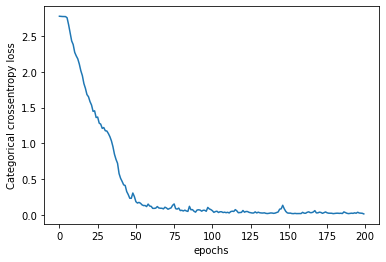

In [25]:
plt.plot(history.history["loss"])
plt.ylabel('Categorical crossentropy loss')
plt.xlabel('epochs')

## LSTM model evaluation
First let us transform the categorical output of the LSTM model to the actual classes

In [26]:
y_pred = np.round(lstm_categorical.predict(lstm_x_test))
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(lstm_y_test, axis=1)

In [27]:
ser = 1 - accuracy_score(y_test, y_pred)
print(f'LSTM:\n SER:\t {ser:.3f}')
acc = accuracy_score(y_test, y_pred)
print(f' Acc:\t {acc:.3f}')

LSTM:
 SER:	 0.039
 Acc:	 0.961


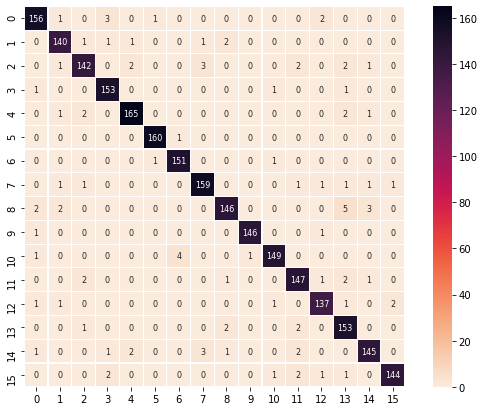

In [28]:
conf_mtx = confusion_matrix(y_test, y_pred)

conf_df = pd.DataFrame(conf_mtx, index = [i for i in range(M)],
                  columns = [i for i in range(M)])
plt.figure(figsize = (10,7))
sns.heatmap(conf_df, cmap=sns.cm.rocket_r, square=True, linewidths=0.1, annot=True, fmt='d', annot_kws={"fontsize": 8})  
plt.show()

## Now let us re-test the Decision tree with the same inputs as the LSTM model

In [29]:
size = feature_mtx.shape[0]
x_train = feature_mtx[:int(0.5*size)] # Split in 50% the dataset in training and test
x_test  = feature_mtx[int(0.5*size):]

y_train = label_mtx[:int(0.5*size)]
y_test  = label_mtx[int(0.5*size):]

In [30]:
class_DT = DecisionTreeClassifier(max_depth=100, random_state=42)
class_DT.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=100, random_state=42)

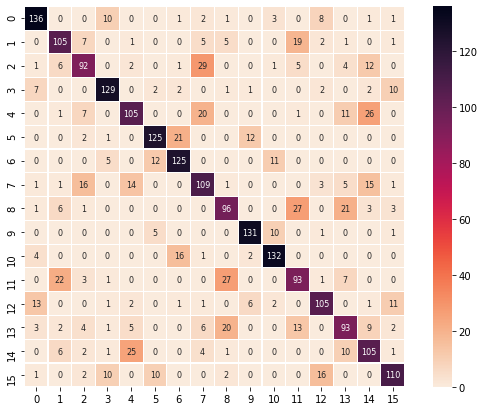

In [31]:
y_pred = class_DT.predict(x_test)
# y_pred = np.argmax(y_pred, axis=1)
# y_test = np.argmax(y_test, axis=1)

conf_mtx = confusion_matrix(y_test, y_pred)

conf_df = pd.DataFrame(conf_mtx, index = [i for i in range(M)],
                  columns = [i for i in range(M)])
plt.figure(figsize = (10,7))
sns.heatmap(conf_df, cmap=sns.cm.rocket_r, square=True, linewidths=0.1, annot=True, fmt='d', annot_kws={"fontsize": 8})  
plt.show()

In [32]:
ser = 1 - accuracy_score(y_test, y_pred)
print(f'Decision Tree:\n SER:\t {ser:.3f}')

acc = accuracy_score(y_test, y_pred)
print(f' Acc:\t {acc:.3f}')

Decision Tree:
 SER:	 0.281
 Acc:	 0.719


## Conclusion
With the values of the accuracy symbol error rate, and the confusion matrix is safe to assume that the LSTM model could understand the cyclic nature of the channel and predict the correct classes for the absolute majority of the test database. Although, the LSTM model is computational costly if compared to simpler models as a decision tree. Thus, the problem should be well analyzed before considering this type of solution, great tools also require great computational power.